# Introduction

*[Inspired by Python notebook](https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb)[ by anokas](https://www.kaggle.com/anokas)*

*by Quentin Vajou*

*April 2017*

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss

pal = sns.color_palette()
%matplotlib inline


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print("File size :")
for f in os.listdir('./input'):
     print(f + '   ' + str(round(os.path.getsize('./input/' + f)/1000000, 2)) + 'MB')

File size :
sample_submission.csv   22.35MB
test.csv   314.02MB
train.csv   63.4MB


In [2]:
df_train = pd.read_csv('./input/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


- **id :** looks like the row ID
- **qid{1, 2} :** unique ID of each question in the pair
- **question{1, 2} :** the text content of the   
   question
- **is_duplicate :** what we're trying to predict : whether   
   the pair of question is a duplicate or not

Nb of question pairs in training set : 404290
Duplicate pairs : 36.92%
total number of questions in the training data : 537933
Number of questions that appear multiple times : 111780


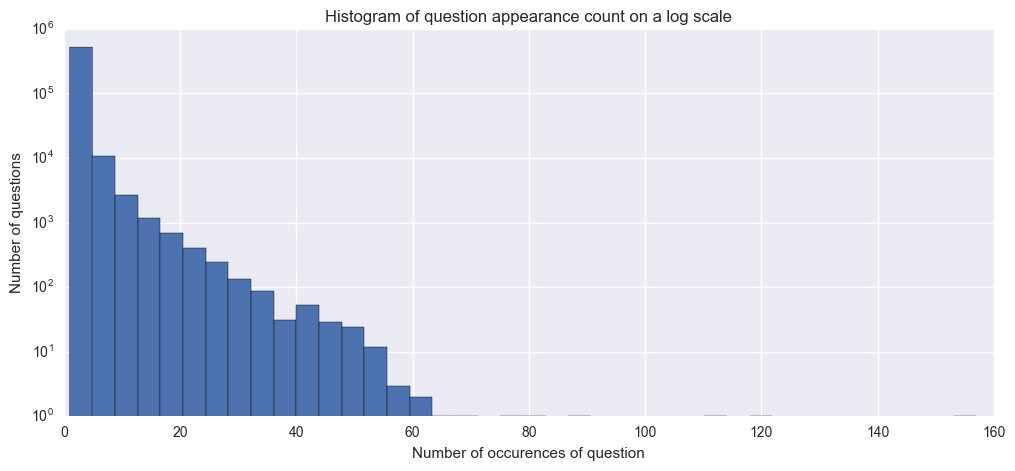

In [3]:
print('Nb of question pairs in training set : {}' .format(len(df_train)))
print('Duplicate pairs : {}%' .format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('total number of questions in the training data : {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times : {}'.format(np.sum(qids.value_counts()>1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=40)
plt.yscale('log', nonposy='clip')
plt.title('Histogram of question appearance count on a log scale')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

## Test Submission

In [4]:
p = df_train["is_duplicate"].mean()
#print(np.zeros_like(df_train["is_duplicate"].head(15)) + p)
#print(df_train["is_duplicate"])
print("Predicted Score : ", log_loss(df_train["is_duplicate"], np.zeros_like(df_train["is_duplicate"]) + p))

df_test = pd.read_csv('./input/test.csv')
#print(df_test.head())
sub = pd.DataFrame({'test_id': df_test["test_id"], 'is_duplicate': p})
sub.to_csv("naive_submission.csv", index=False)
sub.head()

Predicted Score :  0.658527383984


,is_duplicate,test_id
0,0.369198,0
1,0.369198,1
2,0.369198,2
3,0.369198,3
4,0.369198,4


0.55 on the public leaderboard. The discrepency between the leaderboard and the local score (~0.658) indicates that the distribution of value on the leaderboard would lead to problems on the validation set.

## Digging Test set

In [5]:
print(df_test.head())


   test_id                                          question1  \
0        0  How does the Surface Pro himself 4 compare wit...   
1        1  Should I have a hair transplant at age 24? How...   
2        2  What but is the best way to send money from Ch...   
3        3                        Which food not emulsifiers?   
4        4                   How "aberystwyth" start reading?   

                                           question2  
0  Why did Microsoft choose core m3 and not core ...  
1        How much cost does hair transplant require?  
2                      What you send money to China?  
3                                  What foods fibre?  
4                     How their can I start reading?  


In [6]:
print("Total number of questions pairs in testing set : {}".format(len(df_test)))

Total number of questions pairs in testing set : 2345796


2.3 millions questions. As explained in the Data section of the competition theres's a lot of auto-generated data (deter hand-labelling).

## Text Analysis

Let's take a look at what's inside the data. Looking through the train set as the test set contains auto-genrated data.


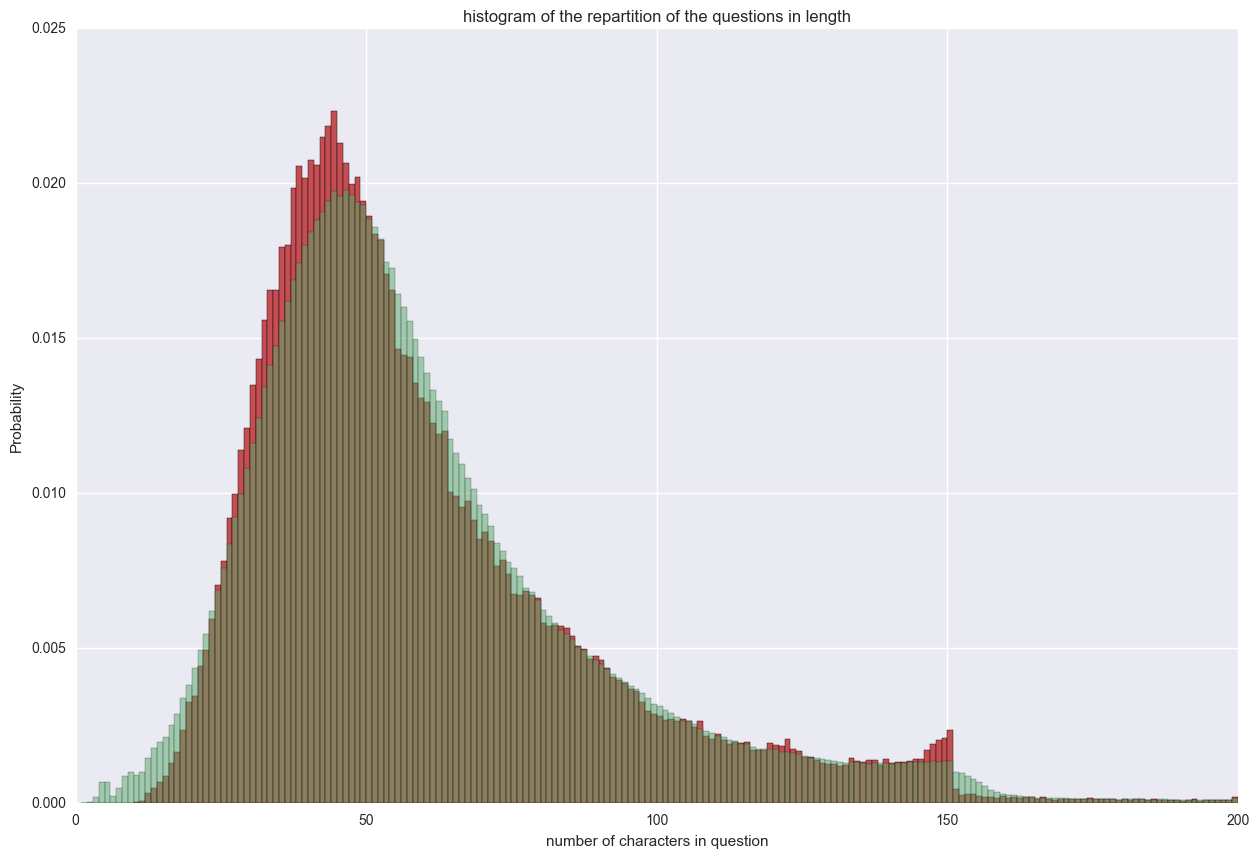

mean-train: 59.82254817086745
std-train:31.963751494576986
max-train: 1169

mean-test: 60.070103282638385
std-test : 31.624631019887765
max-test: 1176


In [7]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)
#print(train_qs.head(15))

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)

plt.figure(figsize=(15,10))
plt.hist(dist_train, bins=200, normed=True, color=pal[2], range=[0,200], label='train')
plt.hist(dist_test, bins=200, normed=True, color=pal[1], range=[0,200], label='test', alpha=0.5)
plt.title('histogram of the repartition of the questions in length')
plt.xlabel('number of characters in question')
plt.ylabel('Probability')
plt.show()

print("mean-train: {}\nstd-train:{}\nmax-train: {}\n\nmean-test: {}\nstd-test : {}\nmax-test: {}".format(dist_train.mean(), dist_train.std(), dist_train.max(), dist_test.mean(), dist_test.std(), dist_test.max()))

Most of the questions have between 15 and 150 characters in them. We can notice a fall at 150 characters on the train set (Quora's limit?). The graph has been cut at 200 for readability purposes. Only a few outliers outside that area.

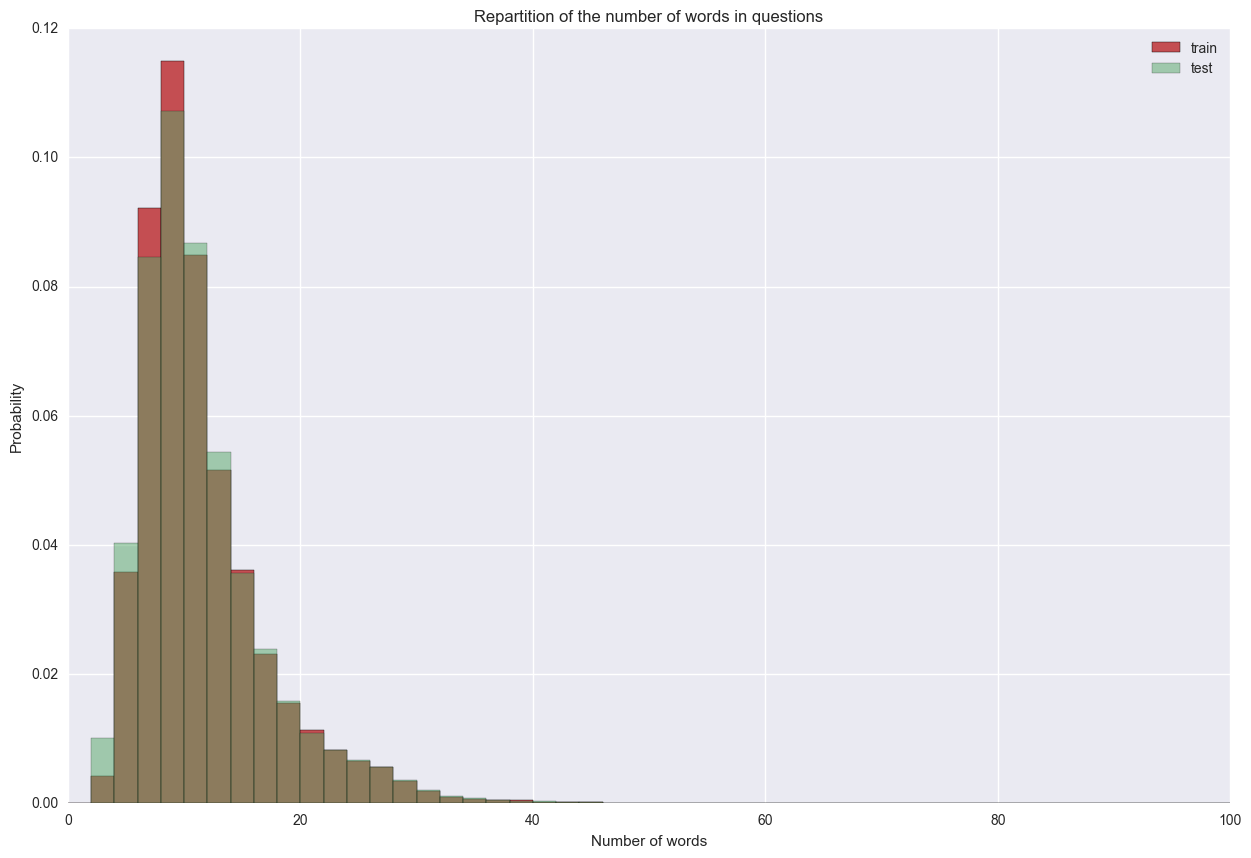

In [8]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15,10))
plt.hist(dist_train, bins=50, normed=True, color=pal[2], range=[0,100], label='train')
plt.hist(dist_test, bins=50, normed=True, color=pal[1], range=[0,100], label='test', alpha=0.5)
plt.title("Repartition of the number of words in questions")
plt.legend()
plt.xlabel("Number of words")
plt.ylabel("Probability")
plt.show()

It looks like the train set is more dense in the number of questions with around mean number of words. Whereas test set seems more spread.

(-0.5, 1439.5, 1079.5, -0.5)

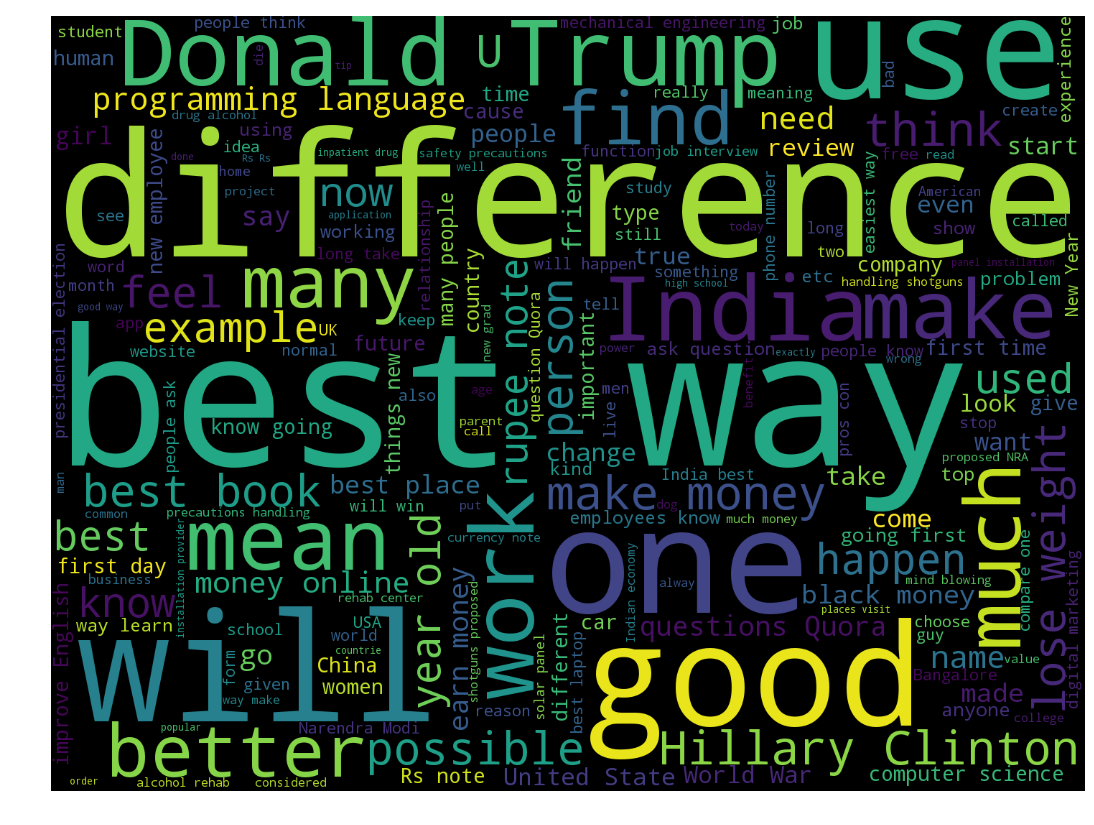

In [9]:
from wordcloud import WordCloud

cloud = WordCloud(width=1440, height=1080).generate("".join(train_qs.astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off')



## Semantic Analysis

In [10]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math_signs = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('? => {:.1f}%'.format(qmarks*100))
print('[math] => {:.1f}%'.format(math_signs*100))
print('. => {:.1f}%'.format(fullstop*100))
print('capital first => {:.1f}%'.format(capital_first*100))
print('capitals => {:.2f}%'.format(capitals*100))
print('numbers => {:.1f}%'.format(numbers*100))

? => 99.9%
[math] => 0.1%
. => 6.3%
capital first => 99.8%
capitals => 99.95%
numbers => 11.8%


## Initial Feature Analysis

In [25]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

pd.options.display.max_colwidth = 100
def match_words_share (row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().replace('?', '').split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().replace('?', '').split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # only stopwrods generated questions
        return 0
    q1words_match = [w for w in q1words.keys() if w in q2words]
    q1words_match = [w for w in q2words.keys() if w in q1words]
    R = (len(q1words_match) + len(q1words_match)) / (len(q1words) + len(q2words))

    return R


In [28]:
%timeit train_word_match = df_train.apply(match_words_share, axis=1, raw=True)

plt.figure(figsize=(15,5))
plt.hist(train_word_match['is_duplicate'] == 1, normed=True, label='is duplicate')
plt.hist(train_word_match['is_duplicate'] == 0, normed=True, label='is not duplicate', alpha=0.5)
plt.title("Repartition of percentage of words in common (out of stopwords)")
plt.xlabel("word match share")
plt.legend()
plt.show()

1 loop, best of 3: 17.3 s per loop


NameError: name 'train_word_match' is not defined